In [1]:
pip install tensorboardcolab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn
import matplotlib.pyplot as plt
import io
import pandas as pd
from PIL import Image
import numpy as np
from numpy import asarray
import cv2
import glob

from tensorflow.keras.applications.resnet50 import ResNet50 # 모델 ResNet50 사용
from sklearn.model_selection import train_test_split

In [4]:
filename =  '/content/drive/Shareddrives/yeja/Garbage classification/garbage_dataset.CSV'
data = pd.read_csv(filename)
data.head()

,imagepath,label,dataset
0,/content/drive/Shareddrives/yeja/Garbage class...,cardboard,test
1,/content/drive/Shareddrives/yeja/Garbage class...,cardboard,test
2,/content/drive/Shareddrives/yeja/Garbage class...,cardboard,test
3,/content/drive/Shareddrives/yeja/Garbage class...,cardboard,test
4,/content/drive/Shareddrives/yeja/Garbage class...,cardboard,test


In [5]:
test_data = data.iloc[:1542,:]
val_data = data.iloc[1543:3087,:]
train_data = data.iloc[3088:35899,:] 

In [6]:
print(train_data.tail())

                                               imagepath  label dataset
35894  /content/drive/Shareddrives/yeja/Garbage class...  trash   train
35895  /content/drive/Shareddrives/yeja/Garbage class...  trash   train
35896  /content/drive/Shareddrives/yeja/Garbage class...  trash   train
35897  /content/drive/Shareddrives/yeja/Garbage class...  trash   train
35898  /content/drive/Shareddrives/yeja/Garbage class...  trash   train


In [7]:
x_train, y_train =  train_data['imagepath'], train_data['label']
x_test, y_test = test_data['imagepath'], test_data['label']
x_val, y_val = val_data['imagepath'], val_data['label']
#이거 절대 다시하지마

In [35]:
y_train = train_data['label']
y_test = test_data['label']
y_val = val_data['label']

In [8]:
y_train = y_train.astype('category')
y_train = y_train.cat.codes

y_test = y_test.astype('category')
y_test = y_test.cat.codes

y_val = y_val.astype('category')
y_val = y_val.cat.codes

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
# y type을 numpy ndarray로 만들기

In [9]:
y_train = np.reshape(y_train, (32811, 1))
y_test = np.reshape(y_test, (1542, 1))
y_val = np.reshape(y_val, (1544, 1))

In [10]:
import os
import cv2
from tqdm import tqdm

image_dim = (150, 150, 3)

images = []
labels = []
for image_path in tqdm(x_train):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)
x_train = np.array(images, dtype='float32')

100%|██████████| 32811/32811 [02:22<00:00, 230.00it/s]


In [11]:
import os
import cv2
from tqdm import tqdm

image_dim = (150, 150, 3)

images1 = []
labels = []
for image_path in tqdm(x_test):
    image1 = cv2.imread(image_path)

    image1 = cv2.resize(
        image1, (image_dim[1], image_dim[0])
    )
    images1.append(image1)
x_test = np.array(images1, dtype='float32')/255.0

100%|██████████| 1542/1542 [00:06<00:00, 223.99it/s]


In [12]:
import os
import cv2
from tqdm import tqdm

image_dim = (150, 150, 3)

images1 = []
labels = []
for image_path in tqdm(x_val):
    image1 = cv2.imread(image_path)

    image1 = cv2.resize(
        image1, (image_dim[1], image_dim[0])
    )
    images1.append(image1)
x_val = np.array(images1, dtype='float32')/255.0

100%|██████████| 1544/1544 [00:07<00:00, 214.96it/s]


In [13]:
print(x_train)

[[[[126. 154. 189.]
   [125. 153. 188.]
   [122. 150. 185.]
   ...
   [116. 141. 167.]
   [117. 142. 168.]
   [117. 142. 168.]]

  [[127. 155. 190.]
   [126. 154. 189.]
   [122. 150. 185.]
   ...
   [120. 145. 170.]
   [122. 147. 173.]
   [122. 147. 173.]]

  [[128. 156. 191.]
   [127. 155. 190.]
   [122. 150. 185.]
   ...
   [121. 146. 172.]
   [121. 146. 172.]
   [121. 146. 172.]]

  ...

  [[156. 194. 229.]
   [153. 191. 226.]
   [157. 191. 227.]
   ...
   [152. 187. 220.]
   [159. 192. 225.]
   [161. 192. 225.]]

  [[156. 193. 229.]
   [153. 191. 226.]
   [157. 191. 227.]
   ...
   [141. 176. 209.]
   [158. 191. 224.]
   [163. 194. 227.]]

  [[153. 191. 226.]
   [154. 192. 227.]
   [158. 192. 228.]
   ...
   [125. 160. 193.]
   [157. 190. 223.]
   [164. 195. 228.]]]


 [[[ 25.  52.  72.]
   [ 25.  52.  72.]
   [ 26.  53.  73.]
   ...
   [186. 226. 251.]
   [181. 222. 247.]
   [182. 222. 247.]]

  [[ 24.  51.  71.]
   [ 24.  51.  71.]
   [ 23.  50.  70.]
   ...
   [186. 226. 251.]
 

In [14]:
x_train = x_train/255.0

In [15]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(32811, 150, 150, 3)
(1544, 150, 150, 3)
(1542, 150, 150, 3)


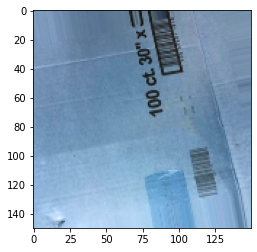

In [16]:
plt.imshow(x_train[0])

In [17]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

In [18]:
print(img_height, img_width) 

150 150


In [19]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
model = InceptionResNetV2()
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [20]:
batch_size = 32
num_classes = 6
epochs = 200

y_train = to_categorical(y_train, num_classes)  # category화(one-hot 인코딩)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [21]:
# load model
model = InceptionResNetV2(include_top=False,input_shape=(img_height, img_width, 3)) 
#imagenet으로 pretrain 된 ResNet50 모델을 224x224 크기 이미지의 훈련에 사용

# summarize the model
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 74, 74, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                

In [22]:
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(64, activation='relu')(flat1)
output = Dense(6, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 74, 74, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                              

In [23]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32811, 6)
(1544, 6)
(1542, 6)


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=200, 
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/200
1026/1026 [==============================] - 202s 173ms/step - loss: 0.6052 - accuracy: 0.7821 - val_loss: 21.9816 - val_accuracy: 0.8193
Epoch 2/200
1026/1026 [==============================] - 173s 169ms/step - loss: 0.4228 - accuracy: 0.8477 - val_loss: 0.8346 - val_accuracy: 0.7079
Epoch 3/200
1026/1026 [==============================] - 173s 169ms/step - loss: 0.3430 - accuracy: 0.8747 - val_loss: 0.6832 - val_accuracy: 0.7584
Epoch 4/200
1026/1026 [==============================] - 173s 169ms/step - loss: 0.3021 - accuracy: 0.8862 - val_loss: 0.1425 - val_accuracy: 0.9469
Epoch 5/200
1026/1026 [==============================] - 173s 169ms/step - loss: 0.2822 - accuracy: 0.8992 - val_loss: 0.3646 - val_accuracy: 0.8763
Epoch 6/200
1026/1026 [==============================] - 173s 169ms/step - loss: 0.4624 - accuracy: 0.8276 - val_loss: 0.2460 - val_accuracy: 0.9126
Epoch 7/200
1026/1026 [==============================] - 173s 168ms/step - loss: 0.3250 - accuracy: 0.881

In [26]:
from keras.models import load_model
model.save('/content/drive/Shareddrives/yeja/Garbage classification/garbage_classification_model_ver2.h5')

In [25]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

49/49 [==============================] - 3s 64ms/step - loss: 0.0975 - accuracy: 0.9805

loss_and_metrics : [0.09754391014575958, 0.9805447459220886]


In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/drive/Shareddrives/yeja/Garbage classification/model_architecture_ver2.png' )
plot_model(model, to_file='/content/drive/Shareddrives/yeja/Garbage classification/model_shapes_ver2.png', show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
predictions = model.predict(x_test, verbose=1)

49/49 [==============================] - 3s 55ms/step


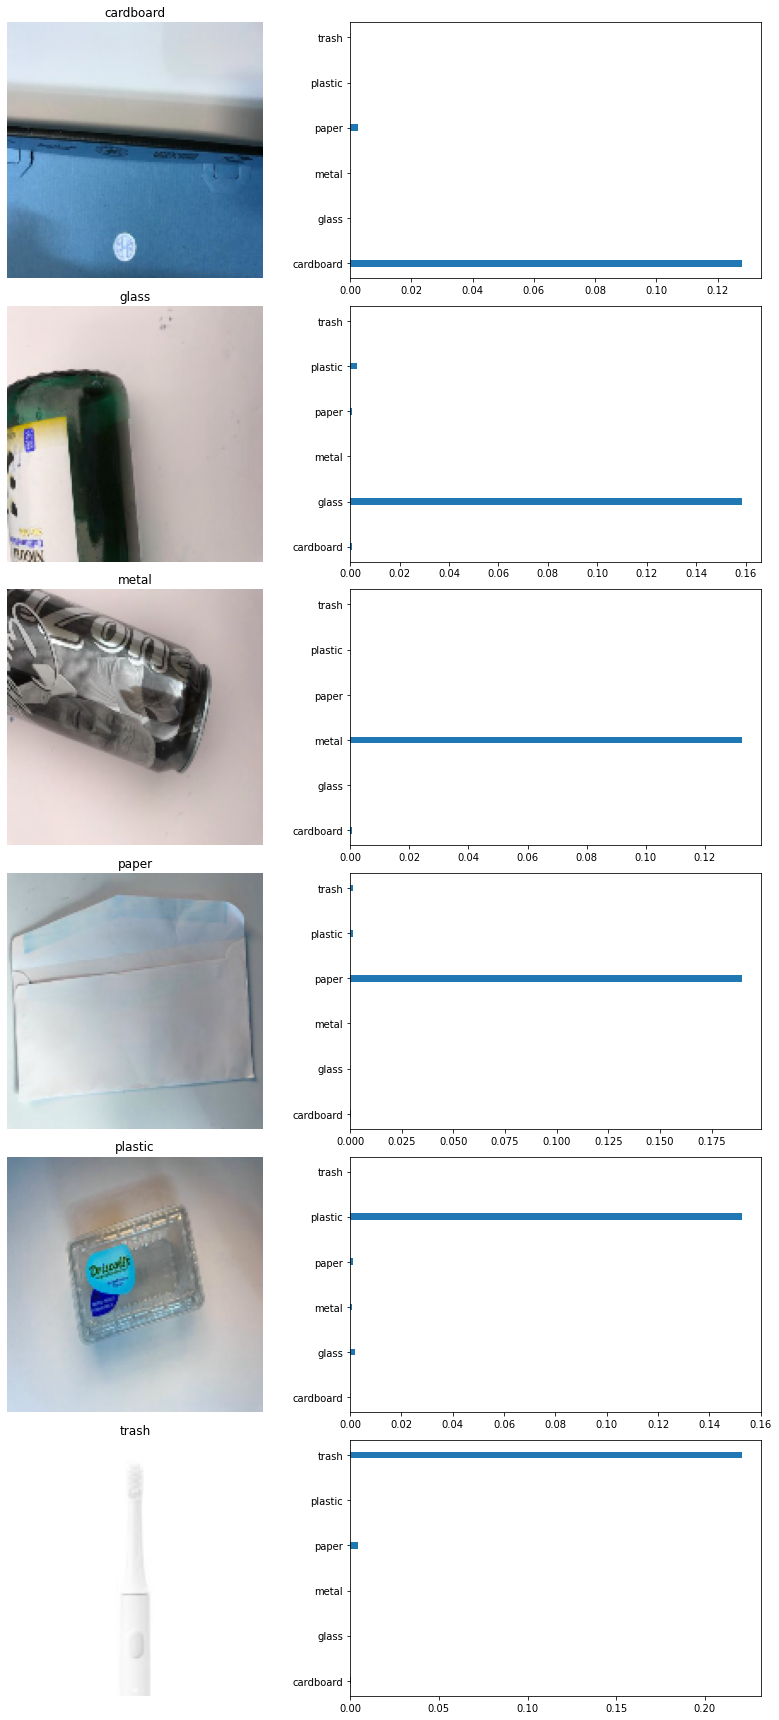

In [37]:
def load_label_names():
    return ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def display_image_predictions(features, labels, predictions):
    n_classes = 6
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(6, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((6, 6))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(6):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)